## A

In [1]:
import sys
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from sklearn import metrics
from torch.autograd import Function
from torch.optim import Adam
from graphviz import Source
from pyeda.boolalg.bdd import bdd2expr

filepath = os.path.abspath('')
sys.path.append(os.path.join(filepath, "..", "..", "compiling_nn"))
from build_odd import compile_nn

pd.options.mode.copy_on_write = True

## B

In [2]:
def cm(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=[False, True])
    return cm_display

def plot_cm(y_true, y_pred):
    cm_display = cm(y_true, y_pred)
    fig, ax = plt.subplots(1, 1, figsize=(4,8))
    cm_display.plot(ax=ax, colorbar=False)

def plot_combine_cm(cms, titles=None):
    n = len(cms)
    fig, axs = plt.subplots(1, n, figsize=(4*n, 8))
    if titles:
        for ax, cm, title in zip(axs, cms, titles):
            cm.plot(ax=ax, colorbar=False)
            ax.set_title(title)
    else:
        for ax, cm in zip(axs, cms):
            cm.plot(ax=ax, colorbar=False)
    fig.tight_layout()

def tnot(a): return torch.logical_not(a)
def tor(a,b): return torch.logical_or(a,b)
def tand(a,b): return torch.logical_and(a,b)
def txor(a,b): return torch.logical_xor(a,b)

In [3]:
class StepFunction(Function):
    @staticmethod
    def forward(ctx, input):
        output = torch.where(input>=0, torch.tensor(1.0), torch.tensor(0.0))
        ctx.save_for_backward(input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = torch.zeros_like(input)
        return grad_input
    
class StepActivation(nn.Module):
    def forward(self, input):
        if self.training:
            return torch.sigmoid(input)
        else:
            return StepFunction.apply(input)
    
class AsymMSELoss(nn.Module): # https://www.desmos.com/calculator/zmxcluqhkt
    def __init__(self, p=2):
        super(AsymMSELoss, self).__init__()
        self.p = p

    def forward(self, input, label):
        dif = label - input
        a = torch.square(dif)
        b = a*self.p
        loss = torch.where(dif < 0, b, a)
        loss = torch.mean(loss)
        return loss

In [4]:
class ApproxNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        hl1 = 25

        self.l1 = nn.Linear(25,hl1)
        self.a1 = StepActivation()
        self.l2 = nn.Linear(hl1,1)
        self.a2 = StepActivation()
        

    def forward(self, x):
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)

        return x

class CentralNet(nn.Module):
    def __init__(self):
        super().__init__()

        hl1 = 25
        hl2 = 15

        self. nn = nn.Sequential(
            nn.Linear(25,hl1),
            nn.Sigmoid(),
            nn.Linear(hl1,hl2),
            nn.Sigmoid(),
            nn.Linear(hl2,1),
            StepActivation(),
        )
    
    def forward(self, x):
        x = self.nn(x)

        return x

class BoundNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # high approx nn (bigger = very long to compute into ODD)
        self.hi = ApproxNet()

        # low approx nn
        self.lo = ApproxNet()

        # nn to approximate (can make it bigger easily)
        self.nn = CentralNet()

    def forward(self, x):
        xhi = self.hi(x)
        xnn = self.nn(x)
        xlo = self.lo(x)
        x = torch.where(xhi>0.5, xhi, torch.where(xlo<0.5, xlo, xnn))
        
        return {"hi": xhi, "nn": xnn, "lo": xlo, "wh": x}

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        hl1 = 50
        hl2 = 50

        self.nn = nn.Sequential(
            nn.Linear(25,hl1),
            nn.Sigmoid(),
            nn.Linear(hl1,hl2),
            nn.Sigmoid(),
            nn.Linear(hl2,1),
            StepActivation(),
        )

    def forward(self, x):
        x = self.nn(x)
        
        return x

## C

In [5]:
df = pd.read_csv("loan_data_set.csv", sep=",")
df = df.drop(columns=["Loan_ID"])

# Remove above 98.5th percentile for 'ApplicantIncome' and 'CoapplicantIncome'
df_rank = df[["ApplicantIncome", "CoapplicantIncome"]]
df_rank["rankA"] = df_rank[["ApplicantIncome"]].rank(pct=True)
df_rank["rankCo"] = df_rank["CoapplicantIncome"].rank(pct=True)

df = df.loc[(df_rank["rankA"]<=0.985) & (df_rank["rankCo"]<=0.985)]
df.index = range(len(df))

# Transform using hot encoding
df_y = pd.get_dummies(df[["Loan_Status"]], drop_first=True)
df_x = df.drop(columns=["Loan_Status"])

nunique = df_x.nunique(axis=0)
df_x_mean = df_x.mean(axis=0, numeric_only=True)

for col, n in nunique.items():
    if n > 4:
        df_x[col] = df_x[col].apply(lambda x : min(4, x//(.5*df_x_mean[col])))

df_x = pd.get_dummies(df_x, columns=df_x.columns, drop_first=True)

# Balance dataset
itrue = df_y.index[df_y["Loan_Status_Y"]==1].tolist()
ifalse = df_y.index[df_y["Loan_Status_Y"]==0].tolist()

swap = len(itrue) > len(ifalse)
if swap:
    itrue,ifalse=ifalse,itrue

ifalse = random.choices(ifalse, k=len(itrue))

if swap:
    itrue,ifalse=ifalse,itrue

print(df_y.iloc[itrue+ifalse].value_counts())

x_train=torch.Tensor(df_x.iloc[itrue+ifalse].to_numpy(dtype=int))
y_train=torch.Tensor(df_y.iloc[itrue+ifalse].to_numpy(dtype=int))

print(x_train.shape, y_train.shape)

Loan_Status_Y
0                184
1                184
dtype: int64
torch.Size([368, 25]) torch.Size([368, 1])


## D

In [6]:
boundnet = BoundNet()

max_epoch = 5000 # less than 5000 can easily lead to one approx predict only one label
learning_rate = 1e-2

# A loss function for each nn
loss_hi_nn = AsymMSELoss(100)
loss_lo_nn = AsymMSELoss(.001)
loss_nn_tr = nn.BCELoss()

# One optimizer for all parameters
optimizer = Adam(boundnet.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    boundnet.train()
    y_pred = boundnet(x_train)
    
    # loss in comparison with true y values
    loss_nn = loss_nn_tr(y_pred["nn"], y_train)

    # losses in comparison to y values of the trained nn
    y_target = y_pred["nn"].detach()
    loss_hi = loss_hi_nn(y_pred["hi"], y_target)
    loss_lo = loss_lo_nn(y_pred["lo"], y_target)

    boundnet.zero_grad()
    loss_nn.backward()
    loss_hi.backward()
    loss_lo.backward()
    optimizer.step()

## E

In [7]:
net = Net()

max_epoch = 5000 # less than 5000 can easily lead to one approx predict only one label
learning_rate = 1e-2

# A loss function for each nn
loss_net = nn.BCELoss()

# One optimizer for all parameters
optimizer = Adam(net.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    net.train()
    y_pred = net(x_train)
    
    # loss in comparison with true y values
    loss = loss_net(y_pred, y_train)

    net.zero_grad()
    loss.backward()
    optimizer.step()

## F

In [8]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def show_activation(act, output):
    # Mean activation per output
    act_ones  = torch.where(output==1, act, torch.zeros(act.size()))
    act_zeros = torch.where(output==0, act, torch.zeros(act.size()))

    mean_ones  = torch.mean(act_ones, dim=0)
    mean_zeros = torch.mean(act_zeros, dim=0)

    # Figure initialization
    fig, ax = plt.subplots(2, 1)
    tick_kw = {'left': False, 'bottom': False, 'labelleft': False}

    # Normalize cmap accross both images
    min_act = min(mean_ones.min().item(), mean_zeros.min().item())
    max_act = max(mean_ones.max().item(), mean_zeros.max().item())

    color_map = 'PRGn'

    ax[0].imshow(mean_zeros.unsqueeze(0), cmap=color_map, vmin=min_act, vmax=max_act)
    ax[0].tick_params(**tick_kw)
    ax[0].set_title("activation moyenne de la couche cachée avec 0 en sortie")

    ax[1].imshow(mean_ones.unsqueeze(0), cmap=color_map, vmin=min_act, vmax=max_act)
    ax[1].tick_params(**tick_kw)
    ax[1].set_title("activation moyenne de la couche cachée avec 1 en sortie")

    # Show text on cells
    for i, (v0, v1) in enumerate(zip(mean_zeros, mean_ones)):
        ax[0].text(i, 0, f"{v0.item():.2f}", ha="center", va="center")
        ax[1].text(i, 0, f"{v1.item():.2f}", ha="center", va="center")
    
    fig.tight_layout()
    plt.show()

def compute_activation(net, layer, data):
    net.eval()
    getattr(net, layer).register_forward_hook(get_activation('__net__'))
    output = net(data).detach()
    act = activation.pop('__net__').squeeze()
    show_activation(act, output)

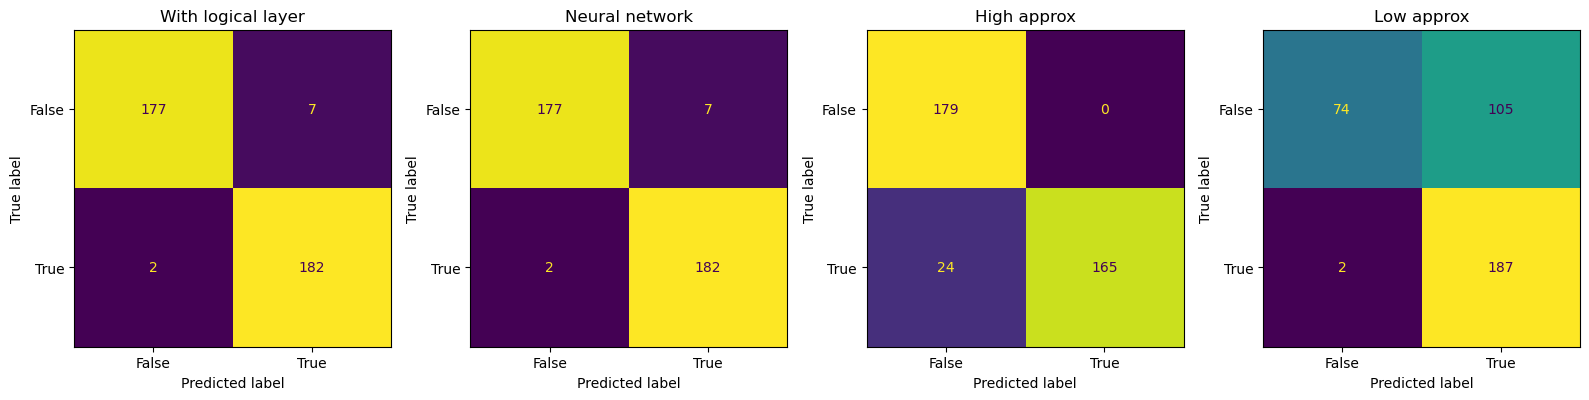

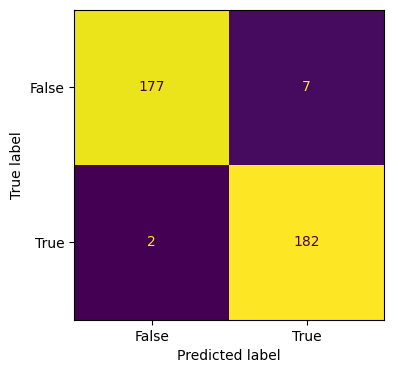

In [9]:
boundnet.eval()
y_pred = boundnet(x_train)

y_pred_wh = y_pred["wh"].detach()
y_pred_nn = y_pred["nn"].detach()
y_pred_hi = y_pred["hi"].detach()
y_pred_lo = y_pred["lo"].detach()

cm_wh = cm(y_train, y_pred_wh)
cm_nn = cm(y_train, y_pred_nn)
cm_hi = cm(y_pred_nn, y_pred_hi)
cm_lo = cm(y_pred_nn, y_pred_lo)

plot_combine_cm([cm_wh, cm_nn, cm_hi, cm_lo], ["With logical layer", "Neural network", "High approx", "Low approx"])

net.eval()
y_pred_net = net(x_train).detach()

plot_cm(y_train, y_pred_net)

In [10]:
f1_b = metrics.f1_score(y_train, y_pred_wh)
f1_n = metrics.f1_score(y_train, y_pred_net)

print(f"F1 score BoundNet \t: {f1_b:.3f}\nF1 score Net \t\t: {f1_n:.3f}")

F1 score BoundNet 	: 0.976
F1 score Net 		: 0.976


In [11]:
def cov_score(y_true, y_pred):
    labels = np.unique(y_true)
    scores = {}

    for label in labels:
        indices_true = np.where(y_true == label)[0]
        indices_pred = np.where(y_pred == label)[0]
        scores[label] = len(np.intersect1d(indices_true, indices_pred))/len(indices_true)

    return scores

cov_hi = cov_score(y_pred_nn, y_pred_hi)
cov_lo = cov_score(y_pred_nn, y_pred_lo)
print(f"Cov score high approx \t: {cov_hi[1]:.3f}\nCov score low approx \t: {cov_lo[0]:.3f}")

Cov score high approx 	: 0.873
Cov score low approx 	: 0.413
